In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import integrate, optimize
import pandas as pd
from scipy.optimize import minimize
from sklearn.metrics import mean_squared_log_error, mean_squared_error
import pandas as pd
import numpy as np
import os
import matplotlib.pylab as plt
import scipy

# loading time series data

url='https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/'
df_confirmed = pd.read_csv(url + 'time_series_covid19_confirmed_global.csv',error_bad_lines=False)  #( time_series_19-covid-Confirmed.csv)
df_recovered = pd.read_csv(url + 'time_series_covid19_recovered_global.csv',error_bad_lines=False) #pd.read_csv("time_series_19-covid-Recovered.csv")
df_deaths = pd.read_csv(url + 'time_series_covid19_deaths_global.csv',error_bad_lines=False) #pd.read_csv("time_series_19-covid-Deaths.csv")
df_confirmed.rename(columns={'Country/Region':'Country'}, inplace=True)
df_recovered.rename(columns={'Country/Region':'Country'}, inplace=True)
df_deaths.rename(columns={'Country/Region':'Country'}, inplace=True)
#df = pd.read_csv(url, error_bad_lines=False)
date='4/2/20'
odir = date.replace('/','_') + '/'
try:  
    os.mkdir(odir)  
except OSError as error:  
    print('Directory exists: ', odir)

df_confirmed=df_confirmed.groupby(["Country"]).sum()
df_confirmed=df_confirmed.drop(columns=['Lat','Long'])
top_affected_countries=df_confirmed.sort_values([date],ascending=False).index[:40].values #20/20

    
df= pd.read_csv("confirmed-data-top-affected-countries.csv")
df_confirmed_top=df_confirmed.loc[top_affected_countries,:]

'''
import os
date='3/29/20'
odir = date.replace('/','_') + '/'

df= pd.read_csv("../countries-spread-rate/"+odir+"confirmed-data-top-affected-countries.csv")
try:  
    os.mkdir(odir)  
except OSError as error:  
    print(error)
'''    

print('countries to choose from: ', df["Country"].values)

# loading population data
df_pop=pd.read_csv("population_by_country_2020.csv")




countries to choose from:  ['US' 'Italy' 'China' 'Spain' 'Germany' 'France' 'Iran' 'United Kingdom'
 'Switzerland' 'Netherlands' 'Belgium' 'Korea, South' 'Turkey' 'Austria'
 'Canada' 'Portugal' 'Norway' 'Brazil' 'Israel' 'Australia' 'Sweden'
 'Czechia' 'Ireland' 'Denmark' 'Malaysia' 'Chile' 'Luxembourg' 'Ecuador'
 'Japan' 'Poland' 'Romania' 'Pakistan' 'Russia' 'Philippines' 'Thailand'
 'Saudi Arabia' 'Indonesia' 'South Africa' 'Finland' 'Greece' 'India'
 'Iceland' 'Panama' 'Dominican Republic' 'Peru' 'Mexico' 'Singapore'
 'Argentina' 'Serbia' 'Slovenia' 'Croatia' 'Diamond Princess' 'Colombia'
 'Estonia' 'Qatar' 'Egypt' 'United Arab Emirates' 'Iraq' 'New Zealand'
 'Algeria' 'Bahrain' 'Morocco' 'Ukraine']


In [2]:
# plot settings
from matplotlib import rc
#matplotlib.rc('text.latex', preamble='\\usepackage{txfonts}')


#rc('text', usetex=True)
#rc('font', family='serif')
#rc('font', serif='times')
rc('mathtext', default='sf')
rc("lines", markeredgewidth=1)
rc("lines", linewidth=2)
rc('axes', labelsize=16)  # 24
rc("axes", linewidth=0.5)  # 2)
rc('xtick', labelsize=14)
rc('ytick', labelsize=14)
rc('legend', fontsize=10)  # 16
rc('xtick.major', pad=6)  # 8)
rc('ytick.major', pad=6)  # 8)
rc('xtick.minor', size=5)  # 8)
rc('ytick.minor', size=5)  # 8)

In [9]:
# get time v/s confirmed cases(10-500) and Ti data for a particular country

def get_data(country,l=14):
    ydata= df[df["Country"]==country].values[0,1:]
    ydata = np.array(ydata, dtype=float)
    idx=np.where(ydata>=50)[0][0]
    idx2= np.where(ydata>1)[0][0]
    ydata=ydata[idx:]
    
    #idx1= np.where(ydata>=1000)[0][0]
    #ydata=ydata[:idx1]
    
    if l!=None:
        ydata = ydata[:l]
    max_days=len(ydata)
    xdata= np.arange(max_days)
    return xdata,ydata, idx-idx2


In [10]:
# SEIIRR Model Parameter Estimation
def seiirr_ivp(x,y,p,beta,Td,Tr,Tl,N):
    S,E,Iu,Id,Rd,Ru = y
#    gamma_eff = (p * Td + (1-p) * Tr )**(-1)
#    beta = R0*gamma_eff  
#    beta = R0/(p*Td)
    sigma = 1/Tl
    Sd = -beta * (Id + Iu) * S/N
    Ed = beta * (Id + Iu) * S/N - sigma * E
    Iud = (1-p) * sigma * E - Iu/Tr
    Idd = p * sigma * E - Id/Td
    Rdd = Id/Td
    Rud = Iu/Tr
    return Sd, Ed, Iud, Idd, Rdd, Rud

def eval_model_seiirr(params,xdata,ydata,Ti,population,return_sol=False): # params: parameters to optimize over: p, beta

    p,beta = params
    N = population
    max_days=len(ydata)

    
    Rd0 = ydata[0]
    E0 = (Rd0 * (Ti + Td) * Tl) / (p * Ti**2)
    Id0 = Rd0 * Td / Ti
    Iu0 = Rd0 * (1/p-1) * (Ti + Td)/(Ti + Tr) * Tr/Tl
    Ru0 = Rd0 * (1/p-1) * (Ti + Td)/(Ti + Tr)
    S0 = N - (Rd0 + E0 + Id0 + Iu0 + Ru0 )
    
    sol = integrate.solve_ivp(seiirr_ivp, [0, max_days], [S0, E0, Iu0, Id0, Rd0, Ru0], args=(p,beta,Td,Tr,Tl,N), 
                    t_eval=xdata,method='RK45')



    optim_days = min(40, max_days)  # Days to optimise for
    weights = 1 / np.arange(1, optim_days+1)[::-1]  

    msle_cases = mean_squared_log_error(ydata[-optim_days:], (sol.y[4,:])[-optim_days:], weights) 

    if return_sol == False:
        return msle_cases
    else:
        return msle_cases,sol
    
import itertools
marker = itertools.cycle(( '*', 'o', '*')) 
no_bounds=((0.01,1),(0.,10.))
def fit_country_seiirr(country, population,bounds=no_bounds):
    N = population

    xdata,ydata,Ti=get_data(country)
    res_const = minimize(eval_model_seiirr,([1., 1.]), bounds=bounds,args=(xdata,ydata,Ti, population),method='L-BFGS-B')

    msle_cases,sol=eval_model_seiirr(res_const.x,xdata,ydata,Ti,population,return_sol=True)
    
    p,beta=res_const.x

    #p,R0obs=res_const.x
    #beta = R0obs/(p*Td)
    
    R0 = beta*(p* Td + (1-p)*Tr)
    R0obs = beta*p*Td
    la = country + ": p = %.2f, "%p +r" $\beta$ =  %3.2f, " %beta + 'MSLE = %.3f \n '%msle_cases + '$R_0$ = %.1f, '%R0 + '$R_0^o$ = %.1f, '%R0obs + '$T_i$ = %d'%Ti 

    plt.plot(sol.t,sol.y[4,:],label = la )
    plt.plot(xdata,ydata,marker=next(marker),linestyle='',label=country,markersize=10)
    plt.yscale('log')
    plt.xlabel('Days')
    plt.ylabel('Confirmed cases fit with $R_d$')
    plt.grid()
    plt.legend(fontsize=14)
    return p,R0,R0obs,msle_cases,sol


46754778


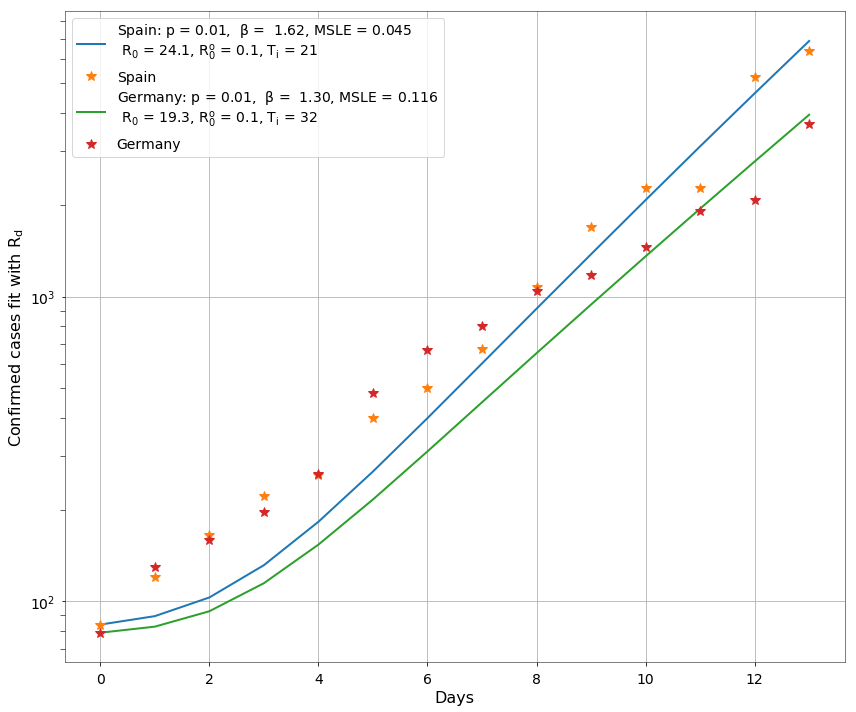

In [29]:
## SEIIRR for Spain and Germany
bounds1=((0.01,.75),(0.,2.5)) # ((pmin,pmax),(beta_min, beta_max))


Tl = 6
Tr = 15
Td = 4

plt.figure(figsize=(12,10))
country='Spain'
population=df_pop[df_pop["Country (or dependency)"]=='Spain']["Population (2020)"].values[0]
_ = fit_country_seiirr(country,population,bounds=bounds1)
print(population)
country='Germany'
population=df_pop[df_pop["Country (or dependency)"]=='Germany']["Population (2020)"].values[0]
_ = fit_country_seiirr(country,population,bounds=bounds1)
plt.grid()
plt.tight_layout()
plt.savefig('p_beta_Spain_Germany.pdf')